# Answering Business Questions using SQL

## Introduction
In this mission we'll be working with a modified version of a database called __[Chinook](https://github.com/lerocha/chinook-database)__. The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store.

The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables.



In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('ggplot')
%matplotlib inline

In [2]:
db = 'chinook.db'

In [3]:
# Creating helper functions

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q,conn)
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)
def show_tables():
    q = 'SELECT name, type FROM sqlite_master WHERE type IN ("table","view");'
    return run_query(q)

In [4]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:


* Regal ------------------> Hip-Hop
* Red Tone----------------> Punk
* Meteor and the Girls----> Pop
* Slim Jim Bites----------> Blues

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

In [5]:
popular_genres_usa = '''
WITH usa_purchases AS 
    (SELECT il.*
    FROM invoice_line il 
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c ON i.customer_id = c.customer_id
    WHERE c.country = 'USA')

SELECT g.name genre,
       COUNT(usp.invoice_line_id) tracks_sold,
       ROUND(CAST(COUNT(usp.invoice_line_id)*100 AS FLOAT) / (
       SELECT COUNT(*) FROM usa_purchases),1) percentage_sold
       
FROM usa_purchases usp
INNER JOIN track t ON t.track_id = usp.track_id
INNER JOIN genre g ON t.genre_id = g.genre_id
GROUP BY 1
ORDER BY 2 DESC
'''
popular_genre_df = run_query(popular_genres_usa)
run_query(popular_genres_usa)

,genre,tracks_sold,percentage_sold
0,Rock,561,53.4
1,Alternative & Punk,130,12.4
2,Metal,124,11.8
3,R&B/Soul,53,5.0
4,Blues,36,3.4
5,Alternative,35,3.3
6,Latin,22,2.1
7,Pop,22,2.1
8,Hip Hop/Rap,20,1.9
9,Jazz,14,1.3


In [6]:
popular_genre_df.set_index("genre", inplace = True, drop = True)
popular_genre_df

,tracks_sold,percentage_sold
genre,,
Rock,561,53.4
Alternative & Punk,130,12.4
Metal,124,11.8
R&B/Soul,53,5.0
Blues,36,3.4
Alternative,35,3.3
Latin,22,2.1
Pop,22,2.1
Hip Hop/Rap,20,1.9


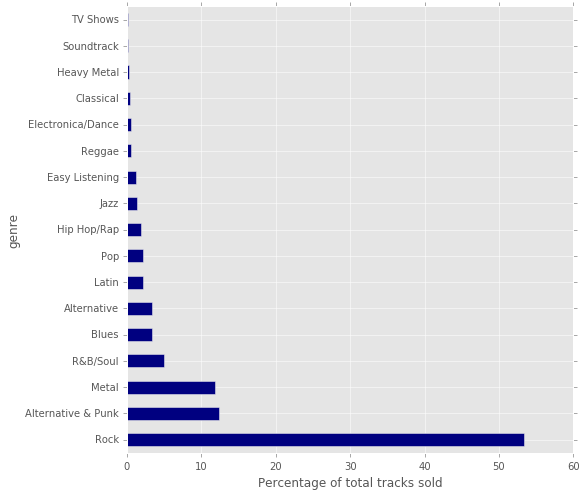

In [7]:
popular_genre_df['percentage_sold'].plot(kind = 'barh', figsize = (8,8), colormap='jet')
plt.xlabel('Percentage of total tracks sold')


The most popular genres in the US appear to be rock, alternative and punk and metal. Based on the findings of this study, it's going to be the most profitable for the store if they purchased the albums by Red Tone, Slim Jim Bites and Meteor and the girls.

It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

## Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We'll analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [8]:
best_sales_agent = '''
SELECT e.first_name || ' ' || e.last_name employee_name,
       e.hire_date,
       SUM(i.total) total_sales
FROM employee e
INNER JOIN customer c ON e.employee_id = c.support_rep_id
INNER JOIN invoice i ON i.customer_id = c.customer_ID
GROUP BY 1
ORDER BY 3
'''
run_query(best_sales_agent)

,employee_name,hire_date,total_sales
0,Steve Johnson,2017-10-17 00:00:00,1393.92
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Jane Peacock,2017-04-01 00:00:00,1731.51


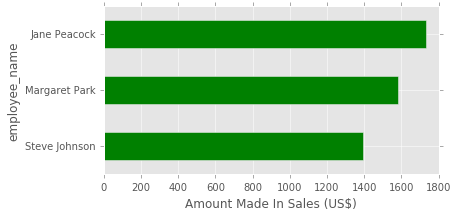

In [9]:
sales_agents_df = run_query(best_sales_agent)
sales_agents_df.set_index("employee_name", inplace = True, drop = True)
sales_agents_df['total_sales'].plot(kind = 'barh', figsize = (6,3), colormap='ocean')
plt.xlabel('Amount Made In Sales (US$)')

Jane Peacock made the most sales, generating 1731.51 USD, which is around 200 USD more than the second best performing sales agent. However, it should be noted that Jane had been on the job for around 4.5 months longer than Margaret Park, who is the secongd best performing sales agent. Steve Johnson manged to generate the least amount of money and sales, but he is the newest member in the sales team.

## Analyzing Sales by Country

We'll now analyze the sales data for customers from each different country. In particular, we will to calculate data, for each country, on the:

* total number of customers
* total value of sales
* average value of sales per customer
* average order value

Because there are a number of countries with only one customer, we will group these customers as "Other" in our analysis.

In [11]:
sales_by_country = '''
WITH country_other AS
(SELECT
  CASE 
    WHEN(SELECT COUNT(*) FROM customer WHERE country = c.country) = 1 THEN "Other"
    ELSE c.country
    END AS country,
    c.customer_id, i.*
FROM customer c
INNER JOIN invoice i ON c.customer_id = i.customer_id
)


SELECT Country, customers, sale_per_customer, sale_per_order
FROM(
SELECT country, 
        COUNT(DISTINCT customer_id) customers, 
        SUM(total) total_sales,
        ROUND(SUM(total) / COUNT(DISTINCT customer_id),2) sale_per_customer,
        ROUND(SUM(total) / COUNT(DISTINCT invoice_id),2) sale_per_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
            END AS sort
        
FROM country_other
GROUP BY 1
ORDER BY sort, total_sales DESC)
'''

run_query(sales_by_country)

,country,customers,sale_per_customer,sale_per_order
0,USA,13,80.04,7.94
1,Canada,8,66.95,7.05
2,Brazil,5,85.54,7.01
3,France,5,77.81,7.78
4,Germany,4,83.66,8.16
5,Czech Republic,2,136.62,9.11
6,United Kingdom,3,81.84,8.77
7,Portugal,2,92.57,6.38
8,India,2,91.57,8.72
9,Other,15,73.00,7.45


USA has the highest number of customers, however, their sale per customer and sale per order is not the highest. Czech Republic, with just 2 customers, have the highest sale per customer and highest sale per order.

In [12]:
sales_country_df = run_query(sales_by_country)
sales_country_df.set_index('country', inplace = True,  drop = True)

In [13]:
sales_country_df

,customers,sale_per_customer,sale_per_order
country,,,
USA,13,80.04,7.94
Canada,8,66.95,7.05
Brazil,5,85.54,7.01
France,5,77.81,7.78
Germany,4,83.66,8.16
Czech Republic,2,136.62,9.11
United Kingdom,3,81.84,8.77
Portugal,2,92.57,6.38
India,2,91.57,8.72


<function matplotlib.pyplot.show>

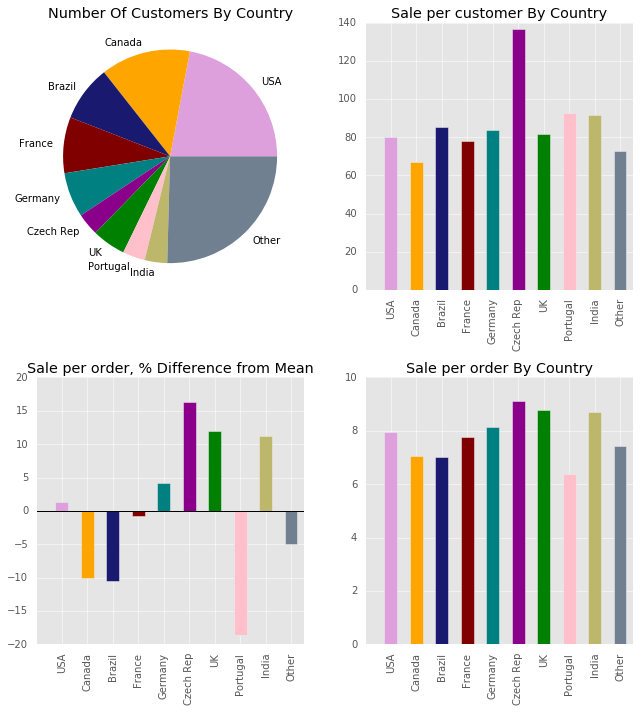

In [14]:
fig = plt.figure(figsize = (9,10))
cs= ['plum', 'orange', 'midnightblue', 'maroon', 'teal', 'darkmagenta', 'green', 'pink', 'darkkhaki','slategray']
list_countries = []
for each in sales_country_df.index:
    if each == 'United Kingdom':
        each = 'UK'
        list_countries.append(each)
    elif each == 'Czech Republic':
        each = 'Czech Rep'
        list_countries.append(each)
    else:
        list_countries.append(each)

#plot1
ax1 = fig.add_subplot(2,2,1)
ax1.pie(sales_country_df['customers'], labels = list_countries, colors = cs, wedgeprops={'linewidth':0})
ax1.set_title('Number Of Customers By Country')

#plot2
ax2 = fig.add_subplot(2,2,2)
ax2.bar(np.arange(10) + 0.75, sales_country_df['sale_per_customer'], 0.5, color = cs)
ax2.set_xticks(range(1,11))
ax2.set_xlim(0,10.5)
ax2.set_xticklabels(list_countries, rotation = 90)
ax2.tick_params(bottom='off', top='off', left='off', right='off')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_title('Sale per customer By Country')

#plot3
mn = sales_country_df['sale_per_order'].mean()
per_diff = ((sales_country_df['sale_per_order'] - mn)/mn) *100

ax4 = fig.add_subplot(2,2,4)
ax4.bar(np.arange(10) + 0.75, sales_country_df['sale_per_order'], 0.5, color = cs)
ax4.set_xticks(range(1,11))
ax4.set_xlim(0,10.5)
ax4.set_xticklabels(list_countries, rotation = 90)
ax4.tick_params(bottom='off', top='off', left='off', right='off')
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.set_title('Sale per order By Country')

#plot4
ax3 = fig.add_subplot(2,2,3)
ax3.bar(np.arange(10) + 0.75, per_diff, 0.5, color = cs)
ax3.set_xticks(range(1,11))
ax3.set_xlim(0,10.5)
ax3.set_xticklabels(list_countries, rotation = 90)
ax3.tick_params(bottom='off', top='off', left='off', right='off')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.axhline(0, c = 'black')
ax3.set_title('Sale per order, % Difference from Mean')

plt.tight_layout()
plt.show

It appears to be that Czech Republic, the UK, and India has the most potential for growth as they have fewer customers than the US and Canada but, their sale per order is significantly higher than average.

It should be noted that only a handful of customers for each country were studied ie. the sample size was very small. The results here may not give an accurate representation of the music industry in these countries.

## Albums vs Individual Tracks

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

* purchase a whole album
* purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

It is very common when you are performing an analysis to have 'edge cases' which prevent you from getting a 100% accurate answer to your question. In this instance, we have two edge cases to consider:

* Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
* Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that the second case does not happen often, so we can ignore this case also.

In order to answer the question, we're going to have to identify whether each invoice has all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks.

In [51]:
albumvtracks = '''
WITH complete_invoice AS
    (SELECT i.invoice_id, t.track_id, SUM(i.total)
     FROM track t
     INNER JOIN invoice_line il ON il.track_id = t.track_id
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     GROUP BY 1)

SELECT album_purchases,
       COUNT(*) number_of_invoices,
       ROUND(CAST(COUNT(*)*100 as float)/(SELECT COUNT(invoice_id) FROM complete_invoice),2) invoice_percentage
FROM
    (SELECT ci.*,
            CASE
                WHEN
                    (SELECT t.track_id FROM track t
                    WHERE t.album_id = (SELECT t.album_id from track t
                                        WHERE t.track_id = ci.track_id)
                    EXCEPT
                
                    SELECT il.track_id FROM invoice_line il
                    WHERE il.invoice_id = ci.invoice_id
                    ) IS NULL
                
                AND
                    (SELECT il.track_id FROM invoice_line il
                    WHERE il.invoice_id = ci.invoice_id
                    
                    EXCEPT
                    
                    SELECT t.track_id FROM track t
                    WHERE t.album_id = (SELECT t.album_id from track t
                                        WHERE t.track_id = ci.track_id)
                    ) IS NULL
                    THEN 'Yes'
                    ELSE 'No'
            END AS album_purchases
        FROM complete_invoice ci
                
    )
GROUP BY album_purchases
'''

run_query(albumvtracks)

,album_purchases,number_of_invoices,invoice_percentage
0,No,500,81.43
1,Yes,114,18.57


Only 18.56% of purchases were complete albums. Therefore, it would be profitable for the store to stop purchasing compete albums.